In [67]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import ast
from ast import literal_eval
%matplotlib inline
from spacy.lang.pt.examples import sentences 


In [68]:
data = pd.read_csv('data/data_clr.csv',index_col=0)

In [69]:
type(data['instrucoes'][2])

str

In [70]:
eval_df = data[2613:]
eval_df.shape

(283, 9)

In [71]:
data = data[:2613]
data.shape

(2613, 9)

In [72]:
import spacy
nlp = spacy.load('pt_core_news_sm', disable=['parser', 'tagger', 'ner'])

In [73]:
tokenized = [nlp(t) for t in data['instrucoes'].values]

In [74]:
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

Number of unique tokens: 10737


In [75]:
type(data['ingredientes'].values)

numpy.ndarray

In [76]:
ingredients = data['ingredientes'].apply(lambda x: literal_eval(str(x)))
ingredients = ingredients.apply(lambda ingredients: list(itertools.chain(*ingredients)))
type(ingredients[0])


list

In [11]:
for i in ingredients[0]:
#     for t in nlp(i):
#         if _filter(t) and len(_clean(t.text)) >= 2:
#             _clean(t.text)
    print(i)

5 unidades de jabuticaba
50ml de cachaça (1 dose)
gelo à gosto


In [12]:
def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

In [13]:
def _clean(text):
    text = text.replace("(", "")
#     text = text.split("/")[0]
    return text

In [14]:
clean = [_clean(t.text) for i in ingredients[0] for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
clean

['unidades', 'jabuticaba', '50ml', 'cachaça', 'dose', 'gelo', 'gosto']

/Users/mattosoerick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W0805 10:10:27.906954 4626490816 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 10:10:28.043475 4626490816 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype

1.14.0
2.2.4-tf


W0805 10:10:28.511855 4626490816 deprecation.py:323] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          536850    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           129       
Total params: 694,675
Trainable params: 694,675
Non-trainable params: 0
__________________________________________________

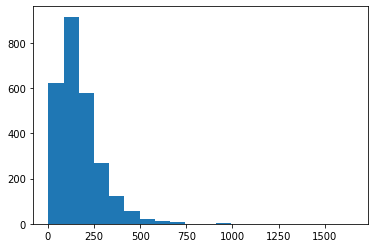

In [15]:
def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels

labels = get_labels(ingredients, tokenized)

set([t.text for t, l in zip(tokenized[214], labels[214]) if l])

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);

MAX_LEN = 400

from keras.preprocessing.sequence import pad_sequences

def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

X_seq[1]

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)


model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))


model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


In [16]:
history = model.fit(X_seq, y_seq, epochs=10, batch_size=256, validation_split=0.1)


Train on 2351 samples, validate on 262 samples
Epoch 1/10
2351/2351 [==============================] - 109s 46ms/sample - loss: 0.2450 - acc: 0.8365 - val_loss: 0.1640 - val_acc: 0.9078
Epoch 2/10
2351/2351 [==============================] - 79s 33ms/sample - loss: 0.1441 - acc: 0.9015 - val_loss: 0.1551 - val_acc: 0.9078
Epoch 3/10
2351/2351 [==============================] - 85s 36ms/sample - loss: 0.1342 - acc: 0.9015 - val_loss: 0.1485 - val_acc: 0.9078
Epoch 4/10
2351/2351 [==============================] - 85s 36ms/sample - loss: 0.1295 - acc: 0.9015 - val_loss: 0.1456 - val_acc: 0.9078
Epoch 5/10
2351/2351 [==============================] - 83s 35ms/sample - loss: 0.1256 - acc: 0.9015 - val_loss: 0.1412 - val_acc: 0.9078
Epoch 6/10
2351/2351 [==============================] - 111s 47ms/sample - loss: 0.1204 - acc: 0.9015 - val_loss: 0.1334 - val_acc: 0.9078
Epoch 7/10
2351/2351 [==============================] - 98s 42ms/sample - loss: 0.1145 - acc: 0.9010 - val_loss: 0.1290 - v

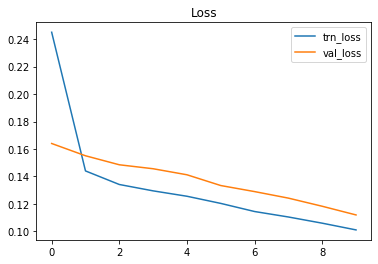

In [17]:
plt.plot(history.history["loss"], label="trn_loss");
plt.plot(history.history["val_loss"], label="val_loss");
plt.legend();
plt.title("Loss");

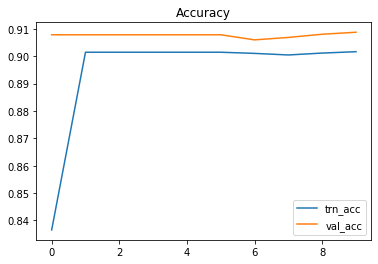

In [18]:
plt.plot(history.history["acc"], label="trn_acc");
plt.plot(history.history["val_acc"], label="val_acc");
plt.legend();
plt.title("Accuracy");


In [19]:
y_pred = model.predict(X_seq, verbose=1, batch_size=1024)


2613/2613 [==============================] - 24s 9ms/sample


In [20]:
i = 334
pred_i = y_pred[i] > 0.05

In [21]:
ingreds = [t.text for t, p in zip(tokenized[i], pred_i) if p]
print(set(ingreds))

{'trigo', 'passe', 'em', '20', 'na', 'coloque', 'Misture', ':', 'Em', 'batidos', '180º', 'creme', '50ml', 'pretas', 'filé', '40', 'e', 'por', '.', 'a', 'gorgonzola', ']', 'Refogue', 'acrescente', 'rosca', 'catupiry', 'mergulhe', 'os', 'queijos', 'cebola', '2', 'Leve', 'medalhão', 'as', 'Sobre', 'tudo', 'restante', 'molho', 'o', 'mozarela', 'ele', "'", '50', 'empanar', 'já', '25', 'no', '[', 'leite', 'fritas', 'seguida', 'parmesão', 'quatro', 'arroz', 'branco', 'de', 'sal', 'ovos', 'tempere', 'Frite', 'com', 'farinha', 'cima', 'feito', 'do', 'manteiga', ',', 'azeitonas', 'batatas', 'frito', 'óleo', 'g', 'dissolva'}


In [22]:
ingreds = [t.text for t, p in zip(tokenized[i], y_seq[i]) if p]
set(ingreds)

{'50ml',
 'azeitonas',
 'catupiry',
 'cebola',
 'creme',
 'empanar',
 'farinha',
 'filé',
 'gorgonzola',
 'leite',
 'manteiga',
 'medalhão',
 'mozarela',
 'ovos',
 'parmesão',
 'pretas',
 'rosca',
 'trigo'}

In [23]:
ingredients[i]


['180g medalhão de filé-mignon',
 '2 unidades ovo',
 'farinha de trigo e de rosca para empanar a gosto',
 '150g mozarela',
 '75g parmesão',
 '60g gorgonzola',
 '120g catupiry',
 '10g azeitonas pretas sem caroço',
 '20g cebola picada',
 '1 colher (sopa) manteiga',
 '50ml creme de leite']

In [24]:
new_labels = []
for pred_i, ti in zip(y_pred, tokenized):
    l_i = []
    ci = [t.text for t, p in zip(tokenized[i], pred_i > 0.05) if p]
    label = []
    for token in ti:
        l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
    new_labels.append(l_i)

In [25]:
y_seq_new = []
for l in new_labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq_new.append(np.array(y_i))
y_seq_new = np.array(y_seq_new)
y_seq_new = y_seq.reshape(y_seq_new.shape[0], y_seq_new.shape[1], 1)

In [26]:
history = model.fit(X_seq, y_seq_new, epochs=1, batch_size=256, validation_split=0.1)


Train on 2351 samples, validate on 262 samples
2351/2351 [==============================] - 123s 52ms/sample - loss: 0.0956 - acc: 0.9027 - val_loss: 0.1041 - val_acc: 0.9094


In [78]:
eval_df = eval_df.reset_index(drop=True)

In [79]:
ingredients_eval_df = eval_df['ingredientes'].apply(lambda x: literal_eval(str(x)))
ingredients_eval_df = ingredients_eval_df.apply(lambda ingredients_eval_df: list(itertools.chain(*ingredients_eval_df)))
type(ingredients_eval_df[0])



list

In [80]:
eval_tokenized = [nlp(t) for t in eval_df['instrucoes'].values]
X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)

In [81]:
y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=1024)


283/283 [==============================] - 3s 10ms/sample


In [82]:
i = 0
pred_i = y_pred_test[i] > 0.05
print(eval_tokenized[i])
print()
print(ingredients_eval_df[i])
print()
ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
print(set(ingreds))

[['Afervente o bacalhau por uns 20 minutos. Escorra e corte-o em cubos pequenos. Aqueça o azeite e adicione o peixe e a maçã. Refogue. Junte o cream cheese, o vinho branco e o creme de leite. Deixe cozinhar por cinco minutos em fogo brando. Tempere com sal e pimenta a gosto. Recheie os folhados com a mistura. Coloque-os numa assadeira e leve ao forno preaquecido por uns cinco minutos ou até os folhados dourarem ligeiramente. Retire do forno, salpique com cebolinha picada e sirva-os como entrada, acompanhados com salada.'], ['', 'Dica:', ' O gelo dessalga o bacalhau mais rápido. Um dia antes de usá-lo, corte-o em pedaços e deixe de molho numa tigela com água e gelo, dentro da geladeira. Troque ambos a cada três horas.']]

['750g de bacalhau dessalgado', '100ml de azeite extravirgem', '300g de maçãs verdes ácidas, sem casca, em cubos pequenos', '120g de cream cheese', '100ml de vinho branco', '200ml de creme de leite fresco', '1 pitada de sal e pimenta-do-reino a gosto', '10 vol-au-vent 

In [92]:
data[filtoriz]['instrucoes'][2613]

"[['Afervente o bacalhau por uns 20 minutos. Escorra e corte-o em cubos pequenos. Aqueça o azeite e adicione o peixe e a maçã. Refogue. Junte o cream cheese, o vinho branco e o creme de leite. Deixe cozinhar por cinco minutos em fogo brando. Tempere com sal e pimenta a gosto. Recheie os folhados com a mistura. Coloque-os numa assadeira e leve ao forno preaquecido por uns cinco minutos ou até os folhados dourarem ligeiramente. Retire do forno, salpique com cebolinha picada e sirva-os como entrada, acompanhados com salada.'], ['', 'Dica:', ' O gelo dessalga o bacalhau mais rápido. Um dia antes de usá-lo, corte-o em pedaços e deixe de molho numa tigela com água e gelo, dentro da geladeira. Troque ambos a cada três horas.']]"

In [93]:
data[filtoriz]['ingredientes'][2613]

"[['750g de bacalhau dessalgado'], ['100ml de azeite extravirgem'], ['300g de maçãs verdes ácidas, sem casca, em cubos pequenos'], ['120g de cream cheese'], ['100ml de vinho branco'], ['200ml de creme de leite fresco'], ['1 pitada de sal e pimenta-do-reino a gosto'], ['10 vol-au-vent (folhados) tamanho 7'], ['1 talo de cebolinha picada a gosto']]"

In [87]:
data = pd.read_csv('data/data_clr.csv',index_col=0)

In [89]:
filtoriz = data['instrucoes'].str.contains('Afervente o bacalhau por uns 20 minutos')